In [237]:
from IPython import display
import pandas as pd
import textwrap
import ast
import glob
import os
import sacredfig
import numpy as np
import matplotlib.pyplot as plt
import json
# import seaborn as sns

# plt.style.use(sacredfig.style)

In [238]:
# import pandas as pd
# import json

combined_path = '/Users/franziskahafner/Desktop/oii/trinity/thesis/experiment_data/prolific_data/combined_experiment_data/'

player_df = pd.read_csv(combined_path + "player_df.csv")
player_df = player_df[player_df["recAlgorithm"]=='random']

SwipeDecision_df = pd.read_csv(combined_path + "SwipeDecision_df.csv")
SwipeDecision_df = SwipeDecision_df[SwipeDecision_df['playerID'].isin(player_df[player_df["recAlgorithm"]=='random']['playerID'])]



character_df = pd.read_csv(combined_path + "character_df.csv")

player_df['chosenProfile'] = player_df['chosenProfile'].astype(int)

elo_data = SwipeDecision_df.merge(player_df[['playerID', 'chosenProfile']], how='left', on='playerID')[['likedProfile', 'dislikedProfile', 'chosenProfile']].dropna()

elo_ratings = {profile: 1500 for profile in range(256)}

elo_history = {profile: [1500] for profile in range(256)}

def update_elo(liked, disliked, chosen, k=32):
    chosen_rating = elo_ratings[chosen]
    
    R1 = elo_ratings[liked]
    E1 = 1 / (1 + 10 ** ((chosen_rating - R1) / 400))
    new_R1 = R1 + k * E1
    elo_ratings[liked] = new_R1
    elo_history[liked].append(new_R1)
    
    R2 = elo_ratings[disliked]
    E2 = 1 / (1 + 10 ** ((R2 - chosen_rating) / 400))
    new_R2 = R2 - k * E2
    elo_ratings[disliked] = new_R2
    elo_history[disliked].append(new_R2)
    
    elo_history[chosen].append(chosen_rating)

for index, row in elo_data.dropna().iterrows():
    update_elo(row['likedProfile'], row['dislikedProfile'], row['chosenProfile'])

sorted_elo = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)

elo_ranking_df = pd.DataFrame(sorted_elo, columns=['Profile', 'Elo Rating'])

elo_json = {str(profile): rating for profile, rating in elo_ratings.items()}
with open('/Users/franziskahafner/Desktop/oii/trinity/thesis/experiment/dating-app-experiment/server/data/elo_ratings.json', 'w') as f:
    json.dump({'profile': elo_json}, f, indent=4)

elo_history_json = {str(profile): ratings for profile, ratings in elo_history.items()}
with open('/Users/franziskahafner/Desktop/oii/trinity/thesis/experiment/dating-app-experiment/server/data/elo_history.json', 'w') as f:
    json.dump({'profile': elo_history_json}, f, indent=4)


In [239]:
elo_ranking_df.to_csv('/Users/franziskahafner/Desktop/oii/trinity/thesis/dating-app-experiment-analysis/elo_ranking_df.csv', index=False)


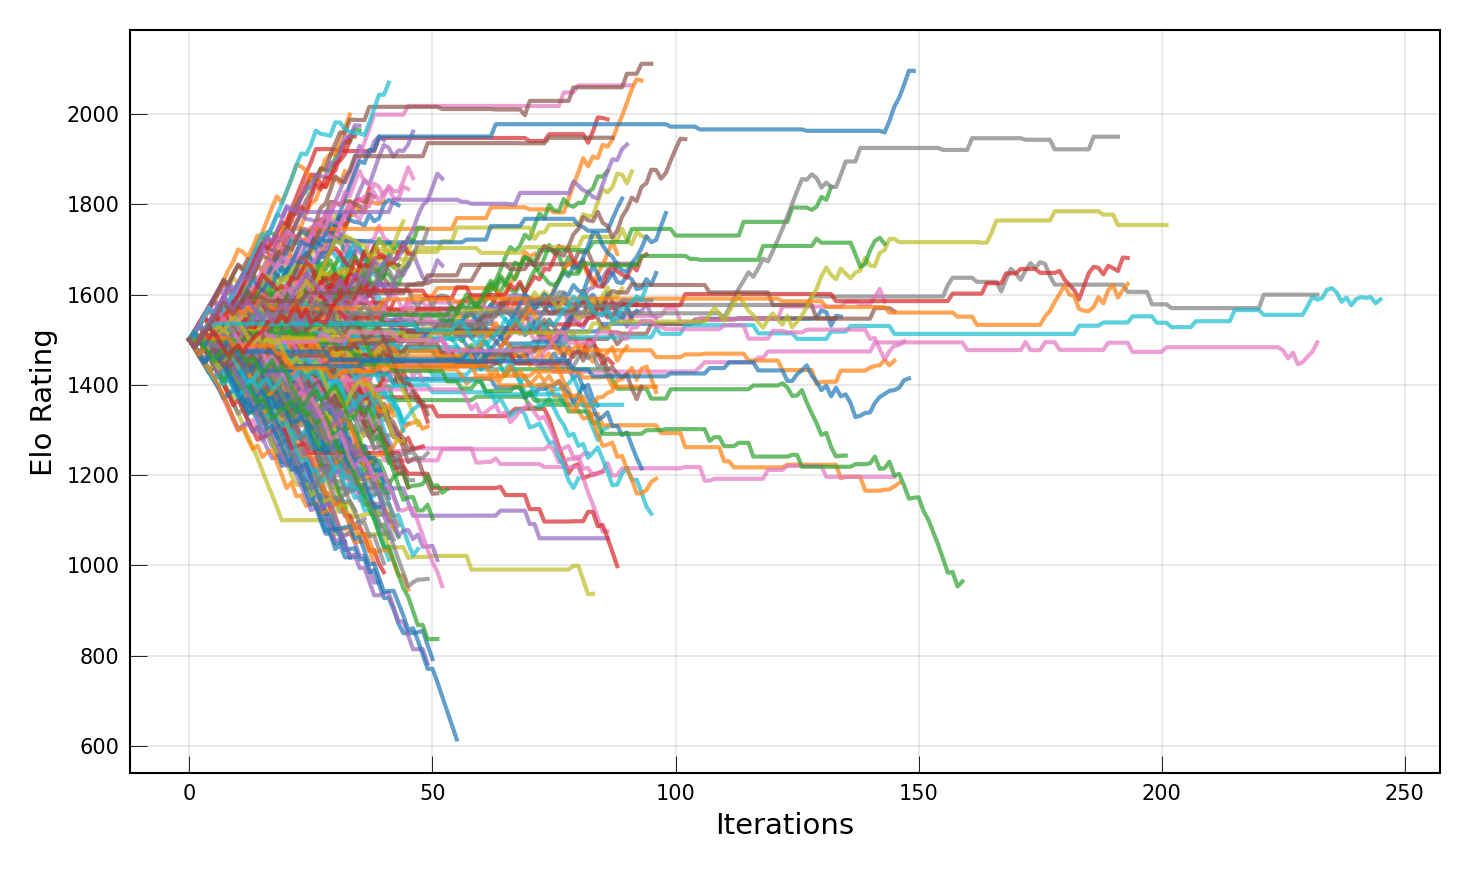

In [240]:
plt.figure(figsize=(5, 3), dpi=300)

for profile, ratings in elo_history.items():
    plt.plot(ratings, label=f'Profile {profile}', alpha=0.7)

plt.xlabel('Iterations')
plt.ylabel('Elo Rating')
plt.grid(True)

plt.tight_layout()

plt.savefig("visualisations/elo_ranking_over_time_all_iterations.png")
plt.show()

In [241]:
def downsample_list(lst, target_length):
    if len(lst) > target_length:
        indices = np.linspace(0, len(lst) - 1, target_length).astype(int)
        return [lst[i] for i in indices]
    return lst

target_length = 35
for profile in elo_history:
    elo_history[profile] = downsample_list(elo_history[profile], target_length)

In [242]:
elo_history_json = {str(profile): ratings for profile, ratings in elo_history.items()}
with open('/Users/franziskahafner/Desktop/oii/trinity/thesis/experiment/dating-app-experiment/server/data/elo_history.json', 'w') as f:
    json.dump({'profile': elo_history_json}, f, indent=4)

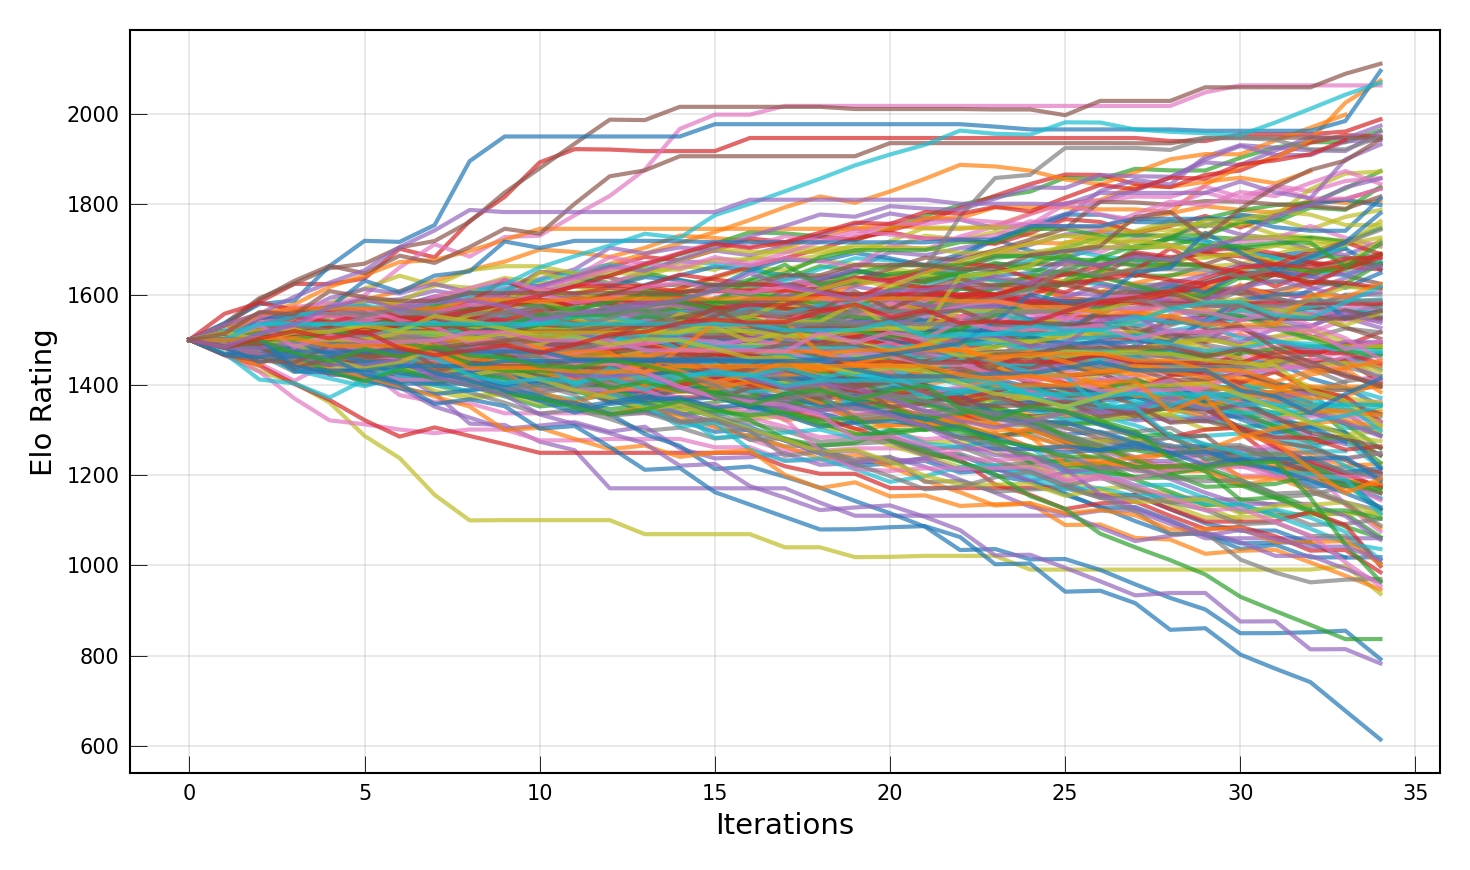

In [243]:
plt.figure(figsize=(5, 3), dpi=300)

for profile, ratings in elo_history.items():
    plt.plot(ratings, label=f'Profile {profile}', alpha=0.7)

plt.xlabel('Iterations')
plt.ylabel('Elo Rating')
plt.title('')
plt.grid(True)

plt.tight_layout()
plt.savefig("visualisations/elo_ranking_over_time_all_condensed_to_35.png")
plt.show()

In [244]:
character_df[character_df['profile_ID']==156]

,accessories,face,facial_hair,hair,pose,skin_tone,age,main_hobby,hobby_1,hobby_2,...,clothes_color,job_type,job,hair_short,face_mood,body_has_color,skin_dark,has_facial_hair,has_accessories,profile_ID
156,GlassesFive,SmileLOL,None,ShortTwo,PolkadotJacket,#73412f,28,Music,Reggae Music,Piano,...,#e69722,No Higher Education Job,Nail Technician,True,positive,True,True,False,True,156


In [245]:
elo_ranking_df[elo_ranking_df['Profile']==156]

,Profile,Elo Rating
87,156,1566.630797


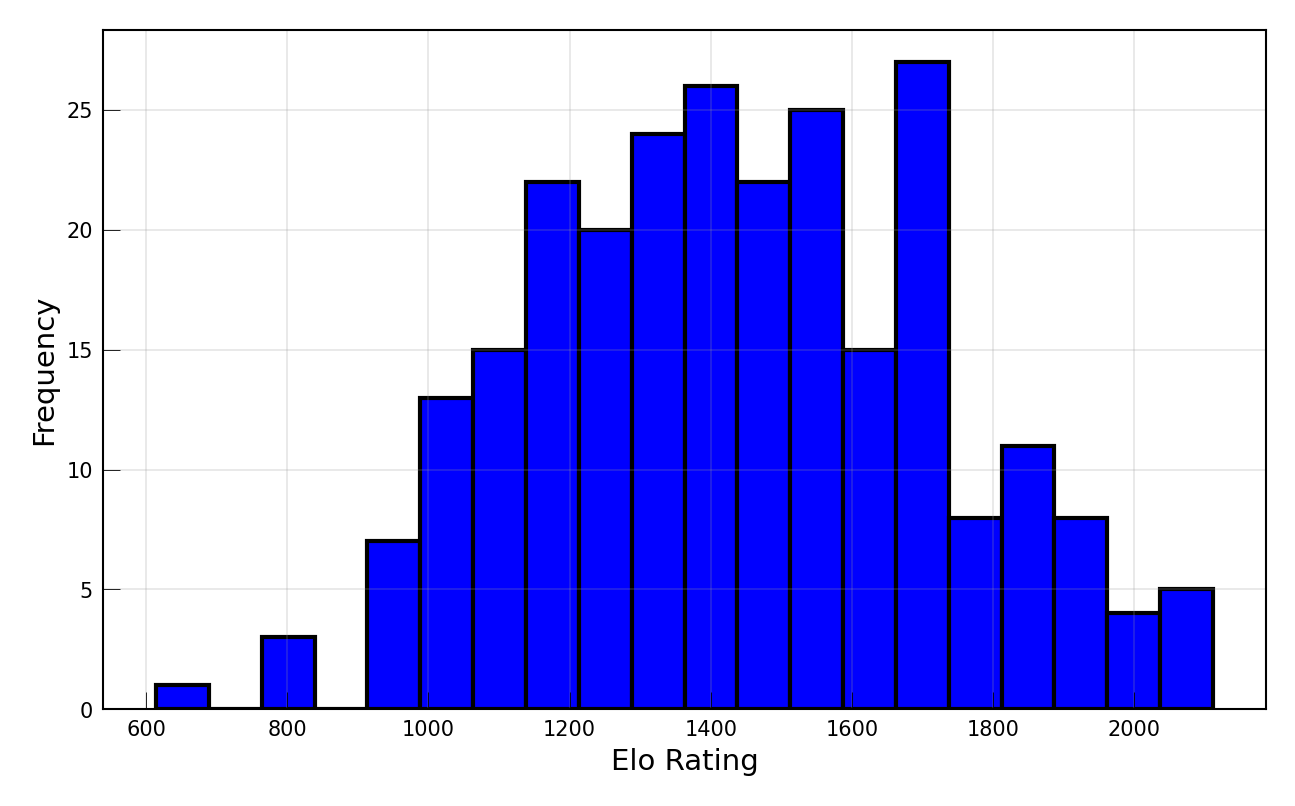

In [246]:
plt.figure(figsize=(5, 3), dpi = 300)
plt.hist(elo_ranking_df['Elo Rating'], bins=20, color='blue', edgecolor='black')
plt.title('')
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("visualisations/elo_distribution.png")

plt.show()

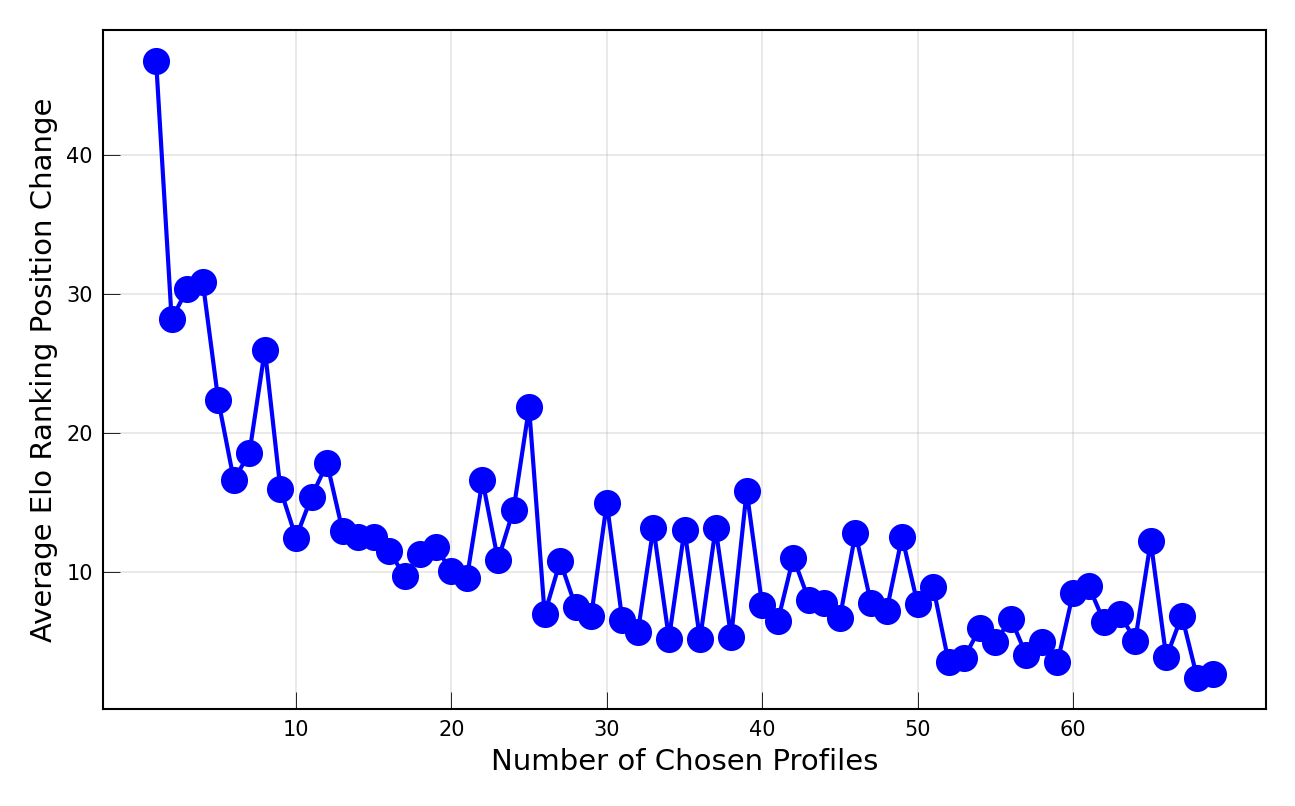

In [248]:
unique_chosen = np.unique(elo_data['chosenProfile'].dropna())
shuffle(unique_chosen)

def calculate_elo(data):
    elo_ratings = {profile: 1500 for profile in range(256)}
    for index, row in data.iterrows():
        update_elo(row['likedProfile'], row['dislikedProfile'], row['chosenProfile'], elo_ratings)
    return elo_ratings

def update_elo(liked, disliked, chosen, elo_ratings, k=32):
    chosen_rating = elo_ratings[chosen]
    R1 = elo_ratings[liked]
    E1 = 1 / (1 + 10 ** ((chosen_rating - R1) / 400))
    elo_ratings[liked] = R1 + k * E1
    R2 = elo_ratings[disliked]
    E2 = 1 / (1 + 10 ** ((R2 - chosen_rating) / 400))
    elo_ratings[disliked] = R2 - k * E2

previous_rankings = None
kendall_tau_scores = []
sorted_profiles = []

for i in range(len(unique_chosen)):
    subset = elo_data[elo_data['chosenProfile'].isin(unique_chosen[:i+1])]
    current_ratings = calculate_elo(subset)
    current_sorted_profiles = sorted(current_ratings, key=current_ratings.get, reverse=True)
    sorted_profiles.append(list(current_sorted_profiles))

changes = []
for i in range(1, len(sorted_profiles)):
    previous_sublist = sorted_profiles[i-1]
    current_sublist = sorted_profiles[i]
    change = sum(abs(previous_sublist.index(x) - current_sublist.index(x)) for x in previous_sublist) / len(previous_sublist)
    changes.append(change)

plt.figure(figsize=(5, 3), dpi=300)
plt.plot(range(1, len(sorted_profiles)), changes, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Chosen Profiles")
plt.ylabel("Average Elo Ranking Position Change")

tick_labels = [i+1 for i in range(1, len(sorted_profiles)-1) if (i+1) % 10 == 0]
plt.xticks(tick_labels)

plt.grid(True)
plt.savefig("visualisations/stability_of_elo_ranking.png")
plt.show()